In [1]:
#Workbench imports
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.optimize import brentq

from workbench_version import * #load the model

In [4]:
from ema_workbench import(RealParameter,ScalarOutcome, Constant, BooleanParameter, CategoricalParameter,
                          Model)

model = Model('UrbanSETP',function=run_model)

model.uncertainties = [CategoricalParameter('SurgeSeries',categories=allSurgeSeries)]
#BooleanParameter('do_adaptation',default=True)

model.levers = [CategoricalParameter('Mayor',categories=[Economicus(),Kroket()])]

model.outcomes = [ScalarOutcome('total_damage_Area0'),
                  ScalarOutcome('total_damage_Area1')]

In [15]:
from ema_workbench import(ema_logging, perform_experiments)

ema_logging.log_to_stderr(ema_logging.INFO)

experiments, outcomes = perform_experiments(models=model,scenarios=4,policies=2)
print(experiments)
print(list(outcomes.keys()))

[MainProcess/INFO] performing 4 scenarios * 2 policies * 1 model(s) = 8 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] 2 cases completed
[MainProcess/INFO] 3 cases completed
[MainProcess/INFO] 4 cases completed
[MainProcess/INFO] 5 cases completed
[MainProcess/INFO] 6 cases completed
[MainProcess/INFO] 7 cases completed
[MainProcess/INFO] 8 cases completed
[MainProcess/INFO] experiments finished


                          SurgeSeries              Mayor scenario policy  \
0      C Scenario C: middle of RCP8.5  Mr. H. Economicus       32     16   
1  D Scenario D: upper part of RCP8.5  Mr. H. Economicus       33     16   
2      B Scenario B: middle of RCP4.5  Mr. H. Economicus       34     16   
3  A Scenario A: lower part of RCP4.5  Mr. H. Economicus       35     16   
4      C Scenario C: middle of RCP8.5       Berry Kroket       32     17   
5  D Scenario D: upper part of RCP8.5       Berry Kroket       33     17   
6      B Scenario B: middle of RCP4.5       Berry Kroket       34     17   
7  A Scenario A: lower part of RCP4.5       Berry Kroket       35     17   

       model  
0  UrbanSETP  
1  UrbanSETP  
2  UrbanSETP  
3  UrbanSETP  
4  UrbanSETP  
5  UrbanSETP  
6  UrbanSETP  
7  UrbanSETP  
['total_damage_Area0', 'total_damage_Area1']


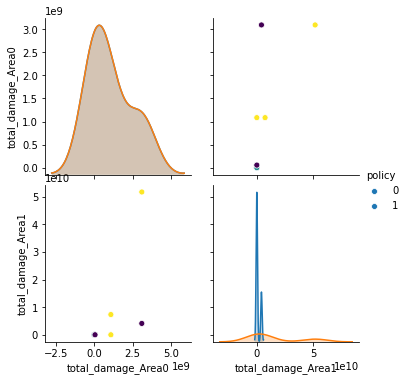

In [11]:
policies = experiments['policy']
for i, policy in enumerate(np.unique(policies)):
    experiments.loc[policies==policy, 'policy'] = str(i)

data = pd.DataFrame(outcomes)
data['policy'] = policies


sns.pairplot(data, hue='policy', vars=list(outcomes.keys()))
plt.show()

# Traditional way to do the visuals

In [2]:
#Model seems to be loaded
experiments = []
for SurgeSeries in allSurgeSeries:
    #print("\n \n {} \n\n------------- \n\n".format(SurgeSeries.name))
    experiment = run_model(Rotty,SurgeSeries,Economicus())
    experiments.append(experiment)
print('experiments finished')

experiments finished


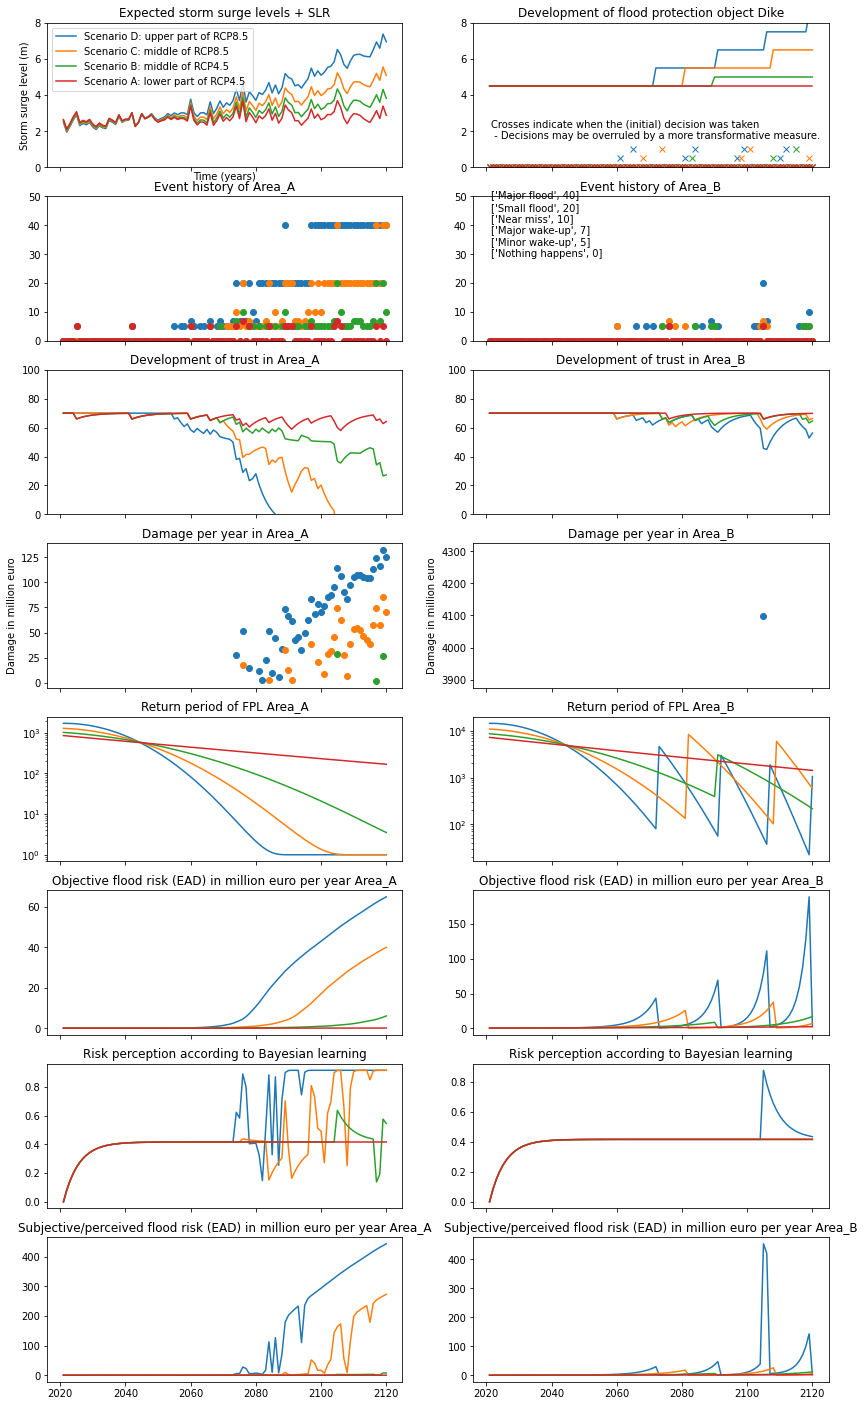

In [3]:
fig, axes = plt.subplots(nrows=8,ncols=2,sharey=False,sharex=True,figsize=(14,25))

labels = []

for experiment in reversed(experiments):
    
    Model = experiment['Model']
    SurgeSeries = experiment['SurgeSeries']
    Mayor = experiment['Mayor']
    
    #print(SurgeSeries.name)
    
    axes[0,0].plot(SurgeSeries.years,SurgeSeries.surgelevel)

    labels.append(SurgeSeries.description)
    axes[0,0].set_title('Expected storm surge levels + SLR')
    axes[0,0].set_xlabel('Time (years)')
    axes[0,0].set_ylabel('Storm surge level (m)')
    axes[0,0].set_ylim(0,8)
    axes[0,1].set_ylim(0,8)

    for i, Area in enumerate(Model.allResidentialArea):
        axes[1,i].set_title('Event history of {}'.format(Area.name))
        axes[1,i].plot(SurgeSeries.years,Model.allResidentialArea[i].event_impact_history,'o')
        axes[1,i].set_ylim(0,50)
        
        axes[2,i].set_title('Development of trust in {}'.format(Area.name))
        axes[2,i].plot(SurgeSeries.years,Model.allResidentialArea[i].trust_t)

        axes[2,i].set_ylim(0,100)
        
        #plot damage
        axes[3,i].set_title('Damage per year in {}'.format(Area.name))
        axes[3,i].plot(SurgeSeries.years,[x*10**(-6) for x in Model.allResidentialArea[i].flood_damage],'o')
    
        axes[4,i].set_title('Return period of FPL {}'.format(Model.allResidentialArea[i].name))
        axes[4,i].plot(SurgeSeries.years,Model.allResidentialArea[i].protection_level_rp,'-')
        axes[4,i].set_yscale("log")
        #axes[1,i].set_ylim(0,50)
    
        axes[5,i].set_title('Objective flood risk (EAD) in million euro per year {}'.format(Model.allResidentialArea[i].name))
        axes[5,i].plot(SurgeSeries.years,Model.allResidentialArea[i].risk,'-')
        #axes[1,i].set_yscale("log")
        #axes[1,i].set_ylim(0,50)
        
        axes[6,i].set_title('Risk perception according to Bayesian learning')
        axes[6,i].plot(SurgeSeries.years,Model.allResidentialArea[i].risk_perception,'-')
        
        axes[7,i].set_title('Subjective/perceived flood risk (EAD) in million euro per year {}'.format(Model.allResidentialArea[i].name))
        axes[7,i].plot(SurgeSeries.years,Model.allResidentialArea[i].risk_perceived,'-')
        #axes[1,i].set_yscale("log")
        #axes[1,i].set_ylim(0,50)
    
    axes[0,1].plot(SurgeSeries.years,Model.allFloodProtection[1].protection_level)
    axes[0,1].set_title('Development of flood protection object Dike')
    
axes[0,0].legend(labels)

axes[3,0].set_ylabel('Damage in million euro')
axes[3,1].set_ylabel('Damage in million euro')

#Add some additional text to some axes
alarming_conditions = Model.Parameters['alarming_conditions']

textbox = ""
for key in alarming_conditions:
    textbox = textbox + str(alarming_conditions[key]) + '\n'

axes[0,1].text(0.05,0.2,"Crosses indicate when the (initial) decision was taken \n - Decisions may be overruled by a more transformative measure.",transform=axes[0,1].transAxes)
axes[1,1].text(0.05,0.5,textbox,transform=axes[1,1].transAxes)


axes[0,1].set_prop_cycle(None) #reset the cycler to plot again in the same axes with similar colors
for experiment in reversed(experiments):
    Model = experiment['Model']
    SurgeSeries = experiment['SurgeSeries']
    Mayor = experiment['Mayor']    
    
    axes[0,1].plot(SurgeSeries.years,Model.allFloodProtection[1].measure_history,'x') #PLOT THE HISTORY OF THE MEASURES
